# Imports

In [21]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter, median_filter, morphological_gradient, binary_dilation, label
from scipy import ndimage
import cv2

# Path to the images
image_folder = "../Data/Week2/qsd2_w2/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

In [22]:
def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0

    # Apply the standard RGB-to-grayscale formula:
    # Luminance = 0.2989 * R + 0.5870 * G + 0.1140 * B
    gray_image = 0.2989 * image[..., 0] + 0.5870 * image[..., 1] + 0.1140 * image[..., 2]

    # Ensure values are in [0, 255] range
    gray_image = np.clip(gray_image * 255, 0, 255).astype(np.uint8)
    
    return gray_image

# Func Principal

In [ ]:
def remove_background_morphological_gradient(image_path, filter=None, save_debug=True):
    # Read the image
    im = imageio.imread(image_path)

    # 0. Preprocess with a Gaussian filter to reduce noise (optional)
    if filter=='gaussian':
        im = gaussian_filter(im, sigma=1)
    elif filter=='median':
        im = median_filter(im, size=3)
    # else no filtering
    
    # 1. Convert from RGB to grayscale
    im_gray = rgb2gray(im)  # Converts to 0-255 range grayscale image

    # 2. Compute morphological gradient to see gradient changes
    grad = morphological_gradient(im_gray, structure=np.ones((5, 5)))

    # 3. Thresholding to highlight the edges
    n = 0.15 # hyperparameter
    threshold = np.max(grad) * n 
    grad_bin = grad > threshold

    # 4. Opening to erase small objects
    mask = binary_opening(grad_bin, structure=np.ones((5, 5)))

    # Ensure we display debug mask when requested
    if save_debug:
        plt.imshow(mask, cmap="gray")
        plt.show()

    # --- New: compute efficient border-pixel mask ---
    # Convert to boolean for vectorized operations
    mask_bool = mask.astype(bool)
    h, w = mask_bool.shape

    # Row-wise extremes (leftmost and rightmost white pixel per row)
    rows_any = mask_bool.any(axis=1)
    left_all = mask_bool.argmax(axis=1)                           # argmax returns 0 when no True; we'll mask those later
    right_all = w - 1 - np.argmax(mask_bool[:, ::-1], axis=1)     # compute rightmost via flipped columns
    left = np.where(rows_any, left_all, -1)
    right = np.where(rows_any, right_all, -1)

    # Column-wise extremes (topmost and bottommost white pixel per column)
    cols_any = mask_bool.any(axis=0)
    top_all = mask_bool.argmax(axis=0)
    bottom_all = h - 1 - np.argmax(mask_bool[::-1, :], axis=0)
    top = np.where(cols_any, top_all, -1)
    bottom = np.where(cols_any, bottom_all, -1)

    # Build border mask by marking the extremes along rows and columns
    border_mask = np.zeros_like(mask_bool, dtype=bool)
    row_inds = np.where(rows_any)[0]
    if row_inds.size > 0:
        border_mask[row_inds, left[row_inds]] = True
        border_mask[row_inds, right[row_inds]] = True
    col_inds = np.where(cols_any)[0]
    if col_inds.size > 0:
        border_mask[top[col_inds], col_inds] = True
        border_mask[bottom[col_inds], col_inds] = True

    #border_mask = binary_dilation(border_mask, np.ones((11,11)))
    #border_mask = binary_opening(border_mask, np.ones((9,9)))


    #PLACEHOLDER!!!!!!!!!!!!!!!!!!!!!!!!!!

    # Prepare final mask (uint8) and apply to image
    mask_rect = border_mask.astype(np.uint8)

    output_image = im * mask_rect[:, :, np.newaxis]
    # Always prepare normalized gradient for visualization and return it
    grad_norm = (255 * (grad.astype(np.float32) - grad.min()) / ( (grad.max() - grad.min()) + 1e-8 )).astype(np.uint8)

    return im, mask_rect, output_image, grad_norm

C:\Users\Adrià\AppData\Local\Temp\ipykernel_2492\2843594173.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)
C:\Users\Adrià\AppData\Local\Temp\ipykernel_2492\1106199881.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_raw = imageio.imread(gt_path)
C:\Users\Adrià\AppData\Local\Temp\ipykernel_2492\1106199881.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.im

00000.jpg -> Precision: 0.8175, Recall: 0.9301, F1: 0.8702


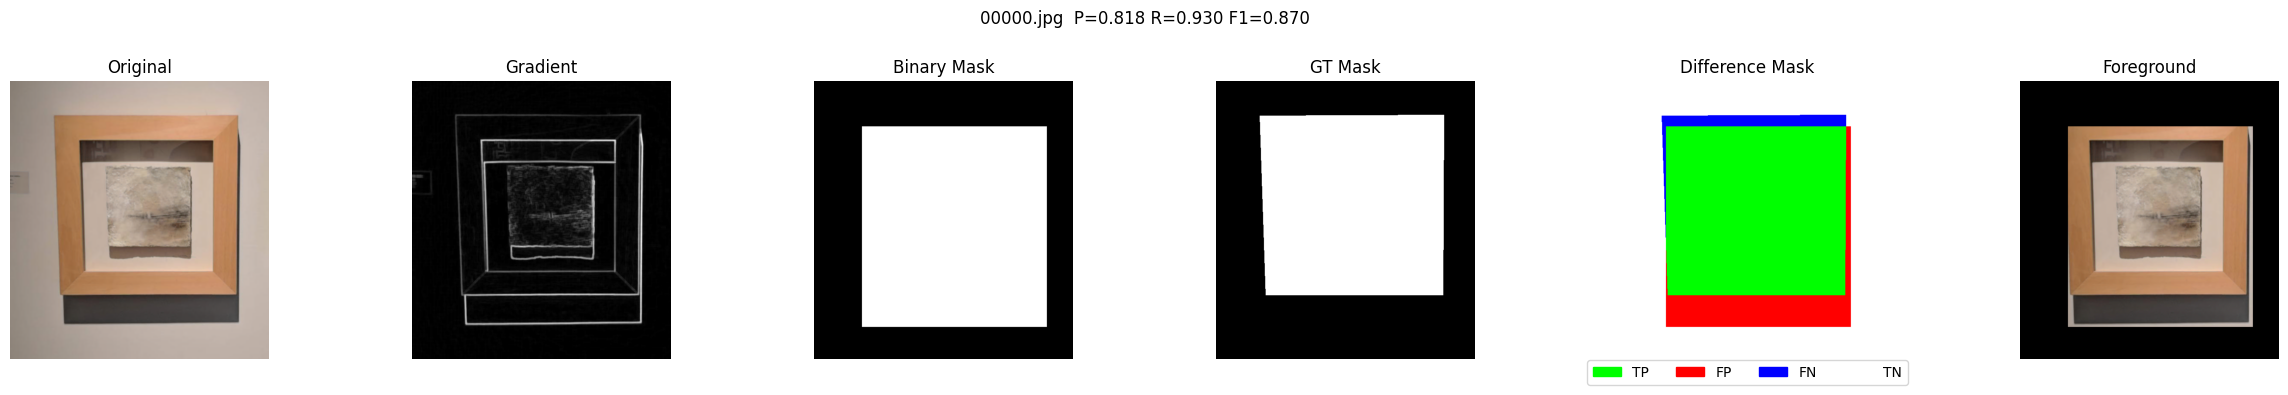

00001.jpg -> Precision: 0.7958, Recall: 0.0370, F1: 0.0707


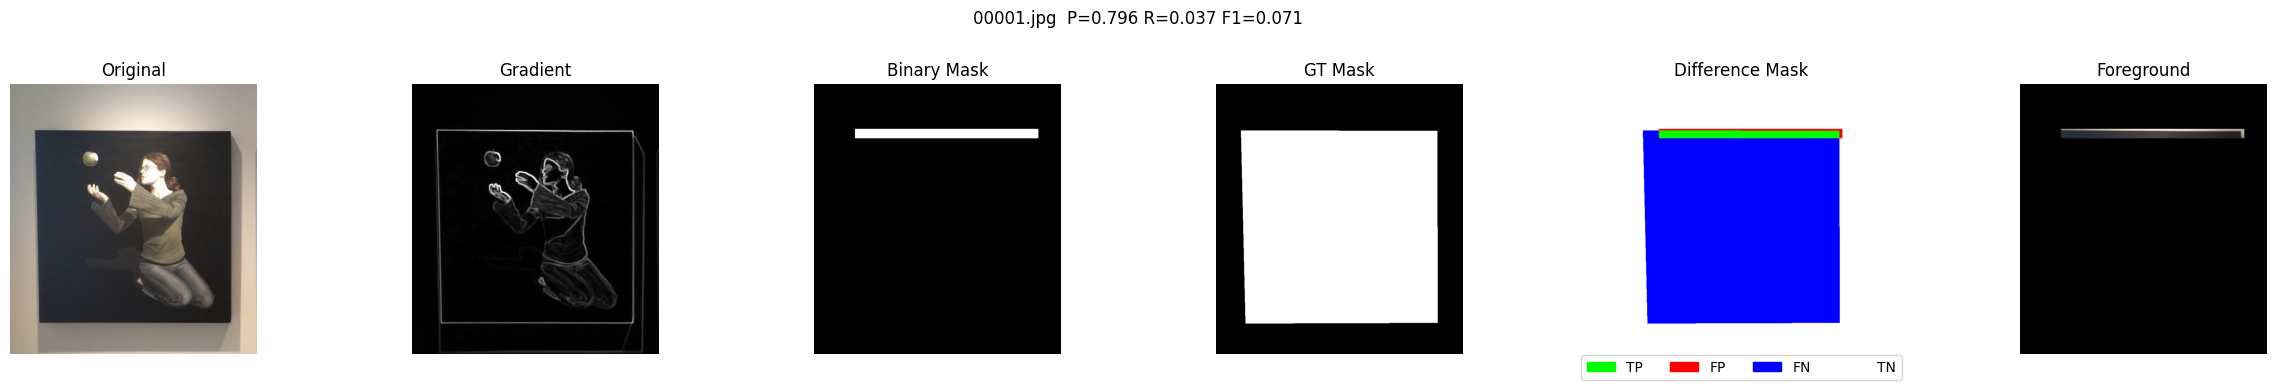

00002.jpg -> Precision: 0.5380, Recall: 1.0000, F1: 0.6996


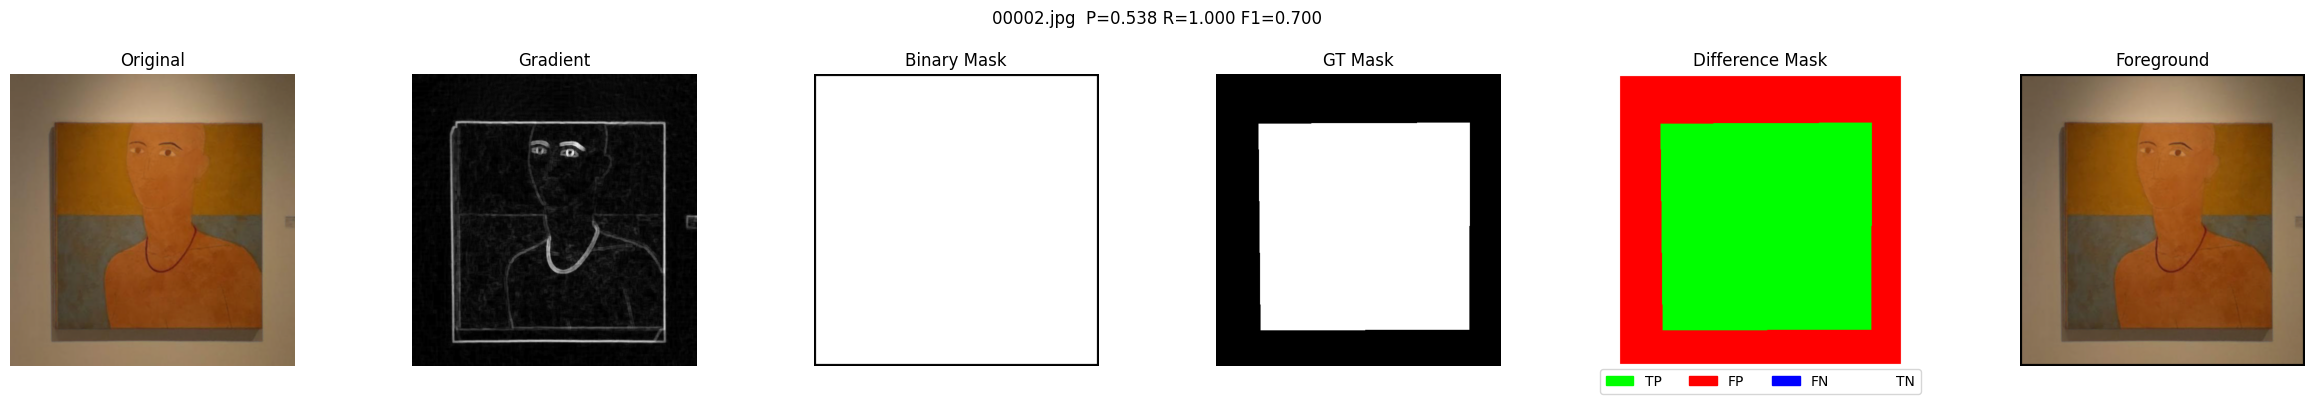

00003.jpg -> Precision: 0.4141, Recall: 0.0038, F1: 0.0076


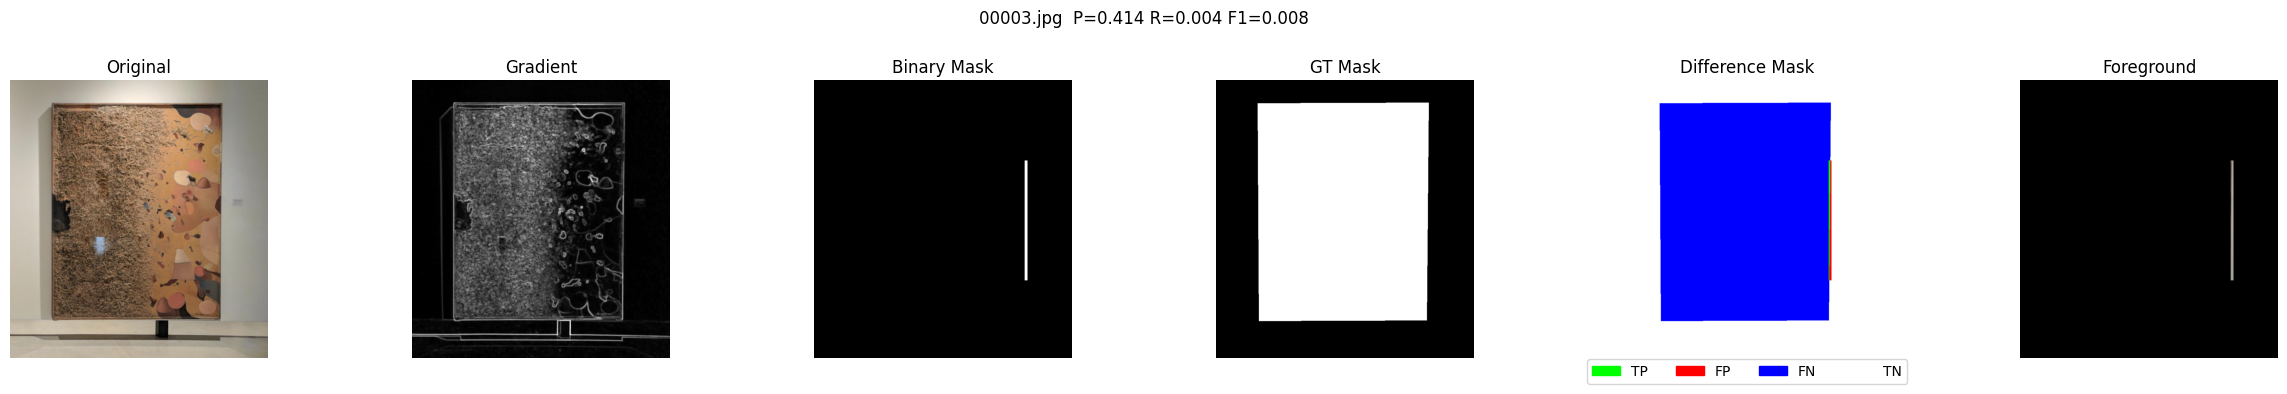

00004.jpg -> Precision: 0.6686, Recall: 0.3627, F1: 0.4703


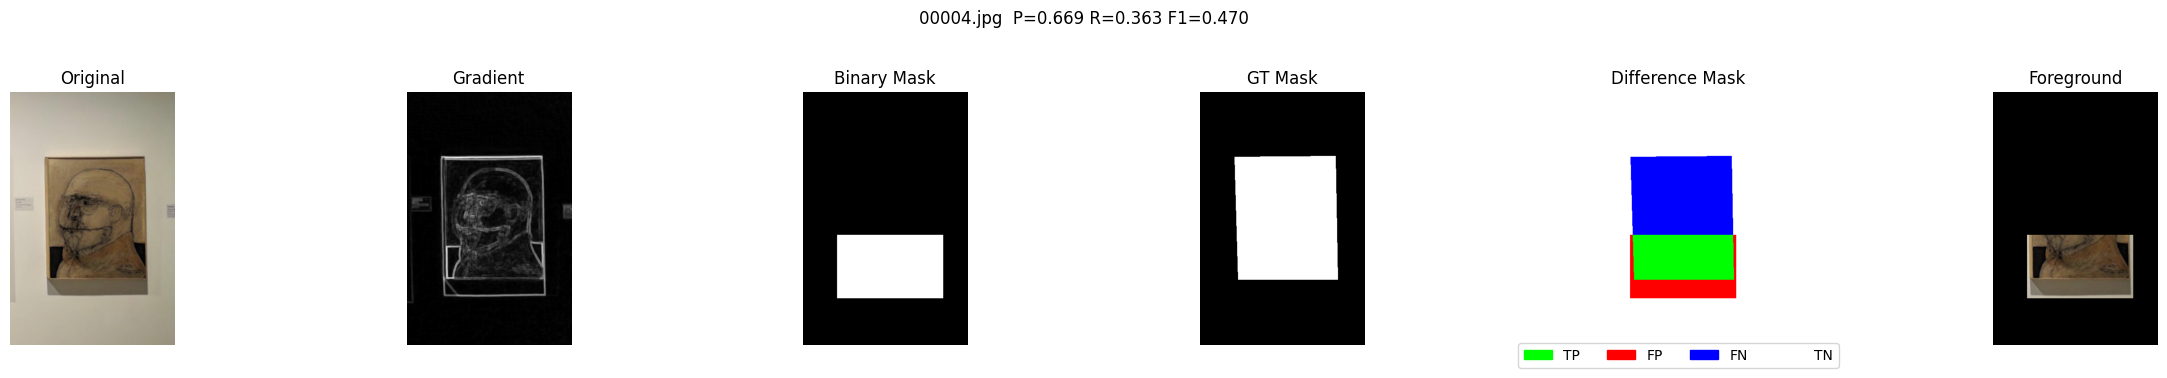

00005.jpg -> Precision: 0.7173, Recall: 0.0014, F1: 0.0029


KeyboardInterrupt: 

In [24]:
# Iterar sobre imágenes, comparar con GT, calcular métricas y mostrar resultados
import matplotlib.patches as mpatches

# Toggle plotting of images. Set to False to speed-up and only print metrics.
SHOW_PLOTS = True

total_TP = total_FP = total_FN = total_TN = 0
precisions = []
recalls = []
f1s = []

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    # Now the function returns the gradient as grad_norm (2D uint8) instead of using a global debug list
    original_image, pred_mask, foreground, grad_norm = remove_background_morphological_gradient(image_path, filter='median', save_debug=False)
    
    # Asegurar máscara booleana predicha
    pred_bool = pred_mask.astype(bool)

    # Cargar GT (mismo nombre .png) y convertir a máscara booleana
    base = os.path.splitext(image_file)[0]
    gt_path = os.path.join(image_folder, base + '.png')
    if os.path.exists(gt_path):
        gt_raw = imageio.imread(gt_path)
        # Si GT tiene canales, convertir a gris
        if gt_raw.ndim == 3:
            gt_gray = rgb2gray(gt_raw)
        else:
            gt_gray = gt_raw
        gt_bool = gt_gray > 127
    else:
        gt_bool = np.zeros(pred_bool.shape, dtype=bool)

    # Calcular TP, FP, FN, TN (por píxel)
    TP = np.logical_and(pred_bool, gt_bool).sum()
    FP = np.logical_and(pred_bool, np.logical_not(gt_bool)).sum()
    FN = np.logical_and(np.logical_not(pred_bool), gt_bool).sum()
    TN = np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)).sum()

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

    # Precision, Recall, F1 para la imagen
    P = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    R = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0

    precisions.append(P)
    recalls.append(R)
    f1s.append(F1)

    print(f"{image_file} -> Precision: {P:.4f}, Recall: {R:.4f}, F1: {F1:.4f}")

    # If plotting is disabled, skip constructing and showing figures
    if not SHOW_PLOTS:
        continue

    # Create image of difference coloured (TP=green, FP=red, FN=blue, TN=white)
    h, w = pred_bool.shape
    diff_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    diff_rgb[np.logical_and(pred_bool, gt_bool)] = [0, 255, 0]     # TP verde
    diff_rgb[np.logical_and(pred_bool, np.logical_not(gt_bool))] = [255, 0, 0]  # FP rojo
    diff_rgb[np.logical_and(np.logical_not(pred_bool), gt_bool)] = [0, 0, 255]  # FN azul
    diff_rgb[np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool))] = [255, 255, 255]  # TN blanco

    # Prepare gradient RGB for display (stack single-channel to 3)
    grad_rgb = np.stack([grad_norm, grad_norm, grad_norm], axis=-1)

    # Mostrar: Original | Gradient | Binary Mask | GT Mask | Difference Mask | Foreground
    plt.figure(figsize=(24, 4))

    plt.subplot(1, 6, 1)
    plt.title('Original')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title('Gradient')
    plt.imshow(grad_rgb)
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.title('Binary Mask')
    plt.imshow(pred_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.title('GT Mask')
    plt.imshow(gt_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.title('Difference Mask')
    plt.imshow(diff_rgb)
    plt.axis('off')

    # Leyenda para Difference Mask
    patches = [
        mpatches.Patch(color=(0, 1, 0), label='TP'),
        mpatches.Patch(color=(1, 0, 0), label='FP'),
        mpatches.Patch(color=(0, 0, 1), label='FN'),
        mpatches.Patch(color=(1, 1, 1), label='TN')
    ]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=4)

    plt.subplot(1, 6, 6)
    plt.title('Foreground')
    plt.imshow(foreground)
    plt.axis('off')

    plt.suptitle(f"{image_file}  P={P:.3f} R={R:.3f} F1={F1:.3f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Métricas globales por píxel (acumuladas)
global_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
global_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
global_f1 = 2 * global_precision * global_recall / (global_precision + global_recall) if (global_precision + global_recall) > 0 else 0.0

print('\n=== Global pixel-wise metrics ===')
print(f'Total TP: {total_TP}, FP: {total_FP}, FN: {total_FN}, TN: {total_TN}')
print(f'Global Precision: {global_precision:.4f}')
print(f'Global Recall:    {global_recall:.4f}')
print(f'Global F1:        {global_f1:.4f}')